In [8]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import numpy as np
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

roads_path = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/infrastructure/roads_20251104/roads.shp'
amenities_path = '/Users/loucas/ORG Dropbox/03_LIBRARY/06 GIS DATA/NYC/amenities/nyc_amenities.shp'

In [9]:
# Load and examine the shapefiles
print("Loading roads...")
roads = gpd.read_file(roads_path)
print(f"Roads shape: {roads.shape}")
print(f"Roads geometry type: {roads.geometry.type.unique()}")
print(f"Roads original CRS: {roads.crs}")

print("\n" + "="*80 + "\n")

print("Loading amenities...")
amenities = gpd.read_file(amenities_path)
print(f"Amenities shape: {amenities.shape}")
print(f"Amenities geometry type: {amenities.geometry.type.unique()}")
print(f"Amenities original CRS: {amenities.crs}")

print("\n" + "="*80 + "\n")

# Convert to UTM Zone 18N (EPSG:32618) - New York City's UTM zone
# This ensures all distance calculations are in meters
NYC_UTM_CRS = "EPSG:32618"

print(f"Converting to {NYC_UTM_CRS} (UTM Zone 18N for NYC)...")
roads = roads.to_crs(NYC_UTM_CRS)
amenities = amenities.to_crs(NYC_UTM_CRS)

print(f"Roads CRS: {roads.crs}")
print(f"Amenities CRS: {amenities.crs}")

print("\nRoads columns:")
print(roads.columns.tolist())
print("\nRoads sample (now in UTM meters):")
print(roads.head())

print("\nAmenities columns:")
print(amenities.columns.tolist())
print("\nAmenities sample (now in UTM meters):")
print(amenities.head())

Loading roads...
Roads shape: (122048, 66)
Roads geometry type: ['LineString' 'MultiLineString']
Roads original CRS: EPSG:4326


Loading amenities...
Amenities shape: (166654, 5)
Amenities geometry type: ['Point']
Amenities original CRS: EPSG:4326


Converting to EPSG:32618 (UTM Zone 18N for NYC)...
Roads CRS: EPSG:32618
Amenities CRS: EPSG:32618

Roads columns:
['physicalid', 'l_low_hn', 'l_high_hn', 'r_low_hn', 'r_high_hn', 'l_zip', 'r_zip', 'status', 'bike_lane', 'trafdir', 'rw_type', 'pre_type', 'post_type', 'objectid', 'fcc', 'l_blockfac', 'r_blockfac', 'avgtravtim', 'rwjurisdic', 'nominaldir', 'accessible', 'nonped', 'boroughcod', 'borough_in', 'seglocstat', 'sandist_in', 'lsubsect', 'rsubsect', 'continuous', 'twisted_pa', 'posted_spe', 'segmentlen', 'streetwidt', 'streetwi_2', 'special_di', 'fire_lane', 'date_creat', 'time_creat', 'date_modif', 'time_modif', 'within_bnd', 'truck_rout', 'collection', 'from_level', 'to_level_c', 'b5sc', 'snow_prior', 'joinid', 'bphys_id', 'carto_d

In [10]:
# Build network graph from roads
def build_network_graph(roads_gdf):
    """
    Build a NetworkX graph from a roads GeoDataFrame.
    Nodes are intersections, edges are road segments with length as weight.
    """
    G = nx.MultiGraph()
    
    print(f"Building network from {len(roads_gdf)} road segments...")
    
    for idx, row in roads_gdf.iterrows():
        if row.geometry.geom_type == 'LineString':
            coords = list(row.geometry.coords)
            
            # Add nodes and edges for the road segment
            for i in range(len(coords) - 1):
                node1 = coords[i]
                node2 = coords[i + 1]
                
                # Calculate segment length in meters
                segment = LineString([node1, node2])
                length = segment.length
                
                # Add edge with length as weight and store original geometry
                G.add_edge(node1, node2, length=length, geometry=segment)
        
        elif row.geometry.geom_type == 'MultiLineString':
            # Handle MultiLineString by processing each LineString
            for line in row.geometry.geoms:
                coords = list(line.coords)
                for i in range(len(coords) - 1):
                    node1 = coords[i]
                    node2 = coords[i + 1]
                    segment = LineString([node1, node2])
                    length = segment.length
                    G.add_edge(node1, node2, length=length, geometry=segment)
    
    print(f"Network built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

# Build the network
G = build_network_graph(roads)

Building network from 122048 road segments...
Network built: 263013 nodes, 310607 edges


In [11]:
# Functions to find starting location
def get_location_from_coordinate(lat, lon, G, crs):
    """
    Convert lat/lon to the nearest network node.
    """
    # Create point in lat/lon (EPSG:4326)
    point = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")
    
    # Convert to roads CRS
    point = point.to_crs(crs)
    target = point.geometry.iloc[0]
    
    # Find nearest node
    nodes = list(G.nodes())
    nearest_node = min(nodes, key=lambda node: Point(node).distance(target))
    
    return nearest_node

def get_location_from_intersection(street1, street2, roads_gdf, G):
    """
    Find the nearest network node to the intersection of two streets.
    Assumes roads have a 'name' or similar field.
    """
    # This requires that roads have street names - adjust column name as needed
    name_col = None
    for col in ['name', 'NAME', 'street', 'STREET', 'FullName', 'FULLNAME']:
        if col in roads_gdf.columns:
            name_col = col
            break
    
    if name_col is None:
        raise ValueError("Could not find street name column in roads data")
    
    # Find roads matching each street name
    road1 = roads_gdf[roads_gdf[name_col].str.contains(street1, case=False, na=False)]
    road2 = roads_gdf[roads_gdf[name_col].str.contains(street2, case=False, na=False)]
    
    if len(road1) == 0:
        raise ValueError(f"No roads found matching '{street1}'")
    if len(road2) == 0:
        raise ValueError(f"No roads found matching '{street2}'")
    
    # Find intersection point
    intersection = road1.unary_union.intersection(road2.unary_union)
    
    if intersection.is_empty:
        raise ValueError(f"Streets '{street1}' and '{street2}' do not intersect")
    
    # Get centroid if multiple intersections
    if hasattr(intersection, 'geoms'):
        intersection = intersection.centroid
    
    # Find nearest node
    nodes = list(G.nodes())
    nearest_node = min(nodes, key=lambda node: Point(node).distance(intersection))
    
    return nearest_node

def get_location_from_amenity(amenity_name, amenities_gdf, G):
    """
    Find the nearest network node to a named amenity.
    """
    # Search for amenity by name - adjust column name as needed
    name_col = None
    for col in ['name', 'NAME', 'amenity', 'AMENITY', 'type', 'TYPE']:
        if col in amenities_gdf.columns:
            name_col = col
            break
    
    if name_col is None:
        raise ValueError("Could not find name column in amenities data")
    
    # Find matching amenities
    matches = amenities_gdf[amenities_gdf[name_col].str.contains(amenity_name, case=False, na=False)]
    
    if len(matches) == 0:
        raise ValueError(f"No amenity found matching '{amenity_name}'")
    
    # Use first match
    target = matches.iloc[0].geometry
    
    # Find nearest node
    nodes = list(G.nodes())
    nearest_node = min(nodes, key=lambda node: Point(node).distance(target))
    
    return nearest_node

In [12]:
# Isochrone generation with different travel modes
def generate_isochrone(G, start_node, max_distance, mode='walk', distance_intervals=None, 
                      use_time=False, max_time=None, time_intervals=None):
    """
    Generate isochrone polygon(s) from a starting node.
    
    Parameters:
    -----------
    G : networkx.Graph
        The network graph
    start_node : tuple
        Starting node coordinates (x, y)
    max_distance : float
        Maximum distance in meters (used if use_time=False)
    mode : str
        Travel mode: 'walk', 'bike', or 'drive'
    distance_intervals : list, optional
        List of distances for multiple isochrones, e.g., [500, 1000, 1500]
        If None, uses only max_distance
    use_time : bool
        If True, use time-based isochrones instead of distance-based
    max_time : float, optional
        Maximum time in minutes (required if use_time=True)
    time_intervals : list, optional
        List of times in minutes for multiple isochrones, e.g., [5, 10, 15]
        If None and use_time=True, uses only max_time
    
    Returns:
    --------
    dict : Dictionary with distance/time as key and polygon geometry as value
    """
    # Define travel speeds (meters per minute)
    speeds = {
        'walk': 80,    # ~4.8 km/h or ~3 mph
        'bike': 250,   # ~15 km/h or ~9.3 mph  
        'drive': 500   # ~30 km/h or ~18.6 mph (urban speed)
    }
    
    if mode not in speeds:
        raise ValueError(f"Mode must be one of {list(speeds.keys())}")
    
    speed = speeds[mode]  # meters per minute
    
    # Determine if we're using time or distance
    if use_time:
        if max_time is None:
            raise ValueError("max_time must be specified when use_time=True")
        
        # Convert time to distance
        max_distance = max_time * speed
        
        # Set up intervals
        if time_intervals is None:
            intervals = [max_time]
            interval_distances = [max_distance]
        else:
            intervals = sorted(time_intervals)
            interval_distances = [t * speed for t in intervals]
    else:
        # Using distance
        if distance_intervals is None:
            intervals = [max_distance]
            interval_distances = [max_distance]
        else:
            intervals = sorted(distance_intervals)
            interval_distances = intervals
    
    # Calculate shortest paths from start node
    try:
        lengths = nx.single_source_dijkstra_path_length(G, start_node, cutoff=max_distance, weight='length')
    except nx.NodeNotFound:
        raise ValueError(f"Start node {start_node} not found in network")
    
    # Build isochrones for each interval
    isochrones = {}
    
    for i, dist in enumerate(interval_distances):
        # Get all nodes within this distance
        reachable_nodes = [node for node, length in lengths.items() if length <= dist]
        
        if len(reachable_nodes) == 0:
            continue
        
        # Create points from reachable nodes
        points = [Point(node) for node in reachable_nodes]
        
        # Use convex hull to create a polygon that expands outward from start
        from shapely.geometry import MultiPoint
        multipoint = MultiPoint(points)
        
        # Use alpha shape or buffer + convex hull for better shape
        # Buffer each point slightly and merge to create smoother boundaries
        buffered = [p.buffer(25) for p in points]  # 25m buffer
        merged = unary_union(buffered)
        
        # Apply convex hull to smooth out the shape
        if hasattr(merged, 'convex_hull'):
            hull = merged.convex_hull
        else:
            hull = merged
        
        # Store the polygon with the original interval value (time or distance)
        isochrones[intervals[i]] = hull
    
    return isochrones

def create_isochrone_geodataframe(isochrones, crs, is_time=False):
    """
    Convert isochrone dictionary to a GeoDataFrame.
    
    Parameters:
    -----------
    isochrones : dict
        Dictionary with distance/time as keys and geometries as values
    crs : CRS
        Coordinate reference system
    is_time : bool
        If True, the keys represent time in minutes; otherwise distance in meters
    """
    data = []
    for value, geom in isochrones.items():
        if is_time:
            data.append({
                'time_minutes': value,
                'geometry': geom
            })
        else:
            data.append({
                'distance': value,
                'geometry': geom
            })
    
    gdf = gpd.GeoDataFrame(data, crs=crs)
    return gdf

In [13]:
# Amenity summary functions
def summarize_amenities_in_isochrone(amenities_gdf, isochrone_geom):
    """
    Find all amenities within an isochrone polygon and summarize them.
    
    Parameters:
    -----------
    amenities_gdf : GeoDataFrame
        Amenities data
    isochrone_geom : Polygon or MultiPolygon
        Isochrone geometry
    
    Returns:
    --------
    DataFrame : Summary statistics of amenities within the isochrone
    """
    # Find amenities within the isochrone
    within = amenities_gdf[amenities_gdf.within(isochrone_geom)].copy()
    
    if len(within) == 0:
        return pd.DataFrame({'message': ['No amenities found within isochrone']})
    
    # Try to find amenity type column
    type_col = None
    for col in ['amenity', 'AMENITY', 'type', 'TYPE', 'category', 'CATEGORY', 'fclass']:
        if col in within.columns:
            type_col = col
            break
    
    if type_col:
        # Count by type
        summary = within[type_col].value_counts().reset_index()
        summary.columns = ['amenity_type', 'count']
        return summary
    else:
        # Just return count
        return pd.DataFrame({
            'total_amenities': [len(within)]
        })

def detailed_amenities_in_isochrone(amenities_gdf, isochrone_geom, start_point=None):
    """
    Get detailed list of amenities within an isochrone.
    
    Parameters:
    -----------
    amenities_gdf : GeoDataFrame
        Amenities data
    isochrone_geom : Polygon or MultiPolygon
        Isochrone geometry
    start_point : Point, optional
        Starting point to calculate distances from
    
    Returns:
    --------
    GeoDataFrame : Amenities within the isochrone with their details
    """
    # Find amenities within the isochrone
    within = amenities_gdf[amenities_gdf.within(isochrone_geom)].copy()
    
    if start_point and len(within) > 0:
        # Calculate distance from start point
        within['distance_from_start'] = within.geometry.distance(start_point)
        within = within.sort_values('distance_from_start')
    
    return within

def assign_amenities_to_isochrones(amenities_gdf, isochrones_dict):
    """
    Assign each amenity to the smallest isochrone polygon it falls within.
    
    Parameters:
    -----------
    amenities_gdf : GeoDataFrame
        Amenities data
    isochrones_dict : dict
        Dictionary with distances as keys and geometries as values
    
    Returns:
    --------
    GeoDataFrame : Amenities with 'isochrone_distance' column indicating which isochrone they're in
    """
    # Create a copy of amenities
    amenities_with_iso = amenities_gdf.copy()
    amenities_with_iso['isochrone_distance'] = None
    
    # Sort distances from smallest to largest
    sorted_distances = sorted(isochrones_dict.keys())
    
    # Assign each amenity to the smallest isochrone it's within
    for dist in sorted_distances:
        geom = isochrones_dict[dist]
        # Find amenities within this isochrone that haven't been assigned yet
        within_mask = amenities_with_iso.within(geom) & amenities_with_iso['isochrone_distance'].isna()
        amenities_with_iso.loc[within_mask, 'isochrone_distance'] = dist
    
    # Filter to only amenities that are within at least one isochrone
    amenities_with_iso = amenities_with_iso[amenities_with_iso['isochrone_distance'].notna()].copy()
    
    return amenities_with_iso

def multi_distance_amenity_summary(amenities_gdf, isochrones_dict):
    """
    Summarize amenities for multiple distance bands.
    
    Parameters:
    -----------
    amenities_gdf : GeoDataFrame
        Amenities data
    isochrones_dict : dict
        Dictionary with distances as keys and geometries as values
    
    Returns:
    --------
    DataFrame : Summary of amenities by distance band
    """
    results = []
    
    sorted_distances = sorted(isochrones_dict.keys())
    
    for i, dist in enumerate(sorted_distances):
        geom = isochrones_dict[dist]
        
        # Find amenities in this ring (current distance minus previous distance)
        if i == 0:
            within = amenities_gdf[amenities_gdf.within(geom)]
        else:
            prev_geom = isochrones_dict[sorted_distances[i-1]]
            # Amenities in current zone but not in previous (ring)
            in_current = amenities_gdf.within(geom)
            in_previous = amenities_gdf.within(prev_geom)
            within = amenities_gdf[in_current & ~in_previous]
        
        # Try to find amenity type column
        type_col = None
        for col in ['amenity', 'AMENITY', 'type', 'TYPE', 'category', 'CATEGORY', 'fclass']:
            if col in amenities_gdf.columns:
                type_col = col
                break
        
        if type_col and len(within) > 0:
            counts = within[type_col].value_counts()
            for amenity_type, count in counts.items():
                results.append({
                    'distance_band': f"0-{dist}m" if i == 0 else f"{sorted_distances[i-1]}-{dist}m",
                    'distance': dist,
                    'amenity_type': amenity_type,
                    'count': count
                })
        else:
            results.append({
                'distance_band': f"0-{dist}m" if i == 0 else f"{sorted_distances[i-1]}-{dist}m",
                'distance': dist,
                'amenity_type': 'all',
                'count': len(within)
            })
    
    return pd.DataFrame(results)

/var/folders/mk/ks8rs6mx6_30xy34h6hr7cs00000gn/T/ipykernel_31093/3265081471.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')
/var/folders/mk/ks8rs6mx6_30xy34h6hr7cs00000gn/T/ipykernel_31093/3265081471.py:118: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  amenity_cmap = plt.cm.get_cmap('Blues')
/var/folders/mk/ks8rs6mx6_30xy34h6hr7cs00000gn/T/ipykernel_31093/3265081471.py:136: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=10, loc='upper ri

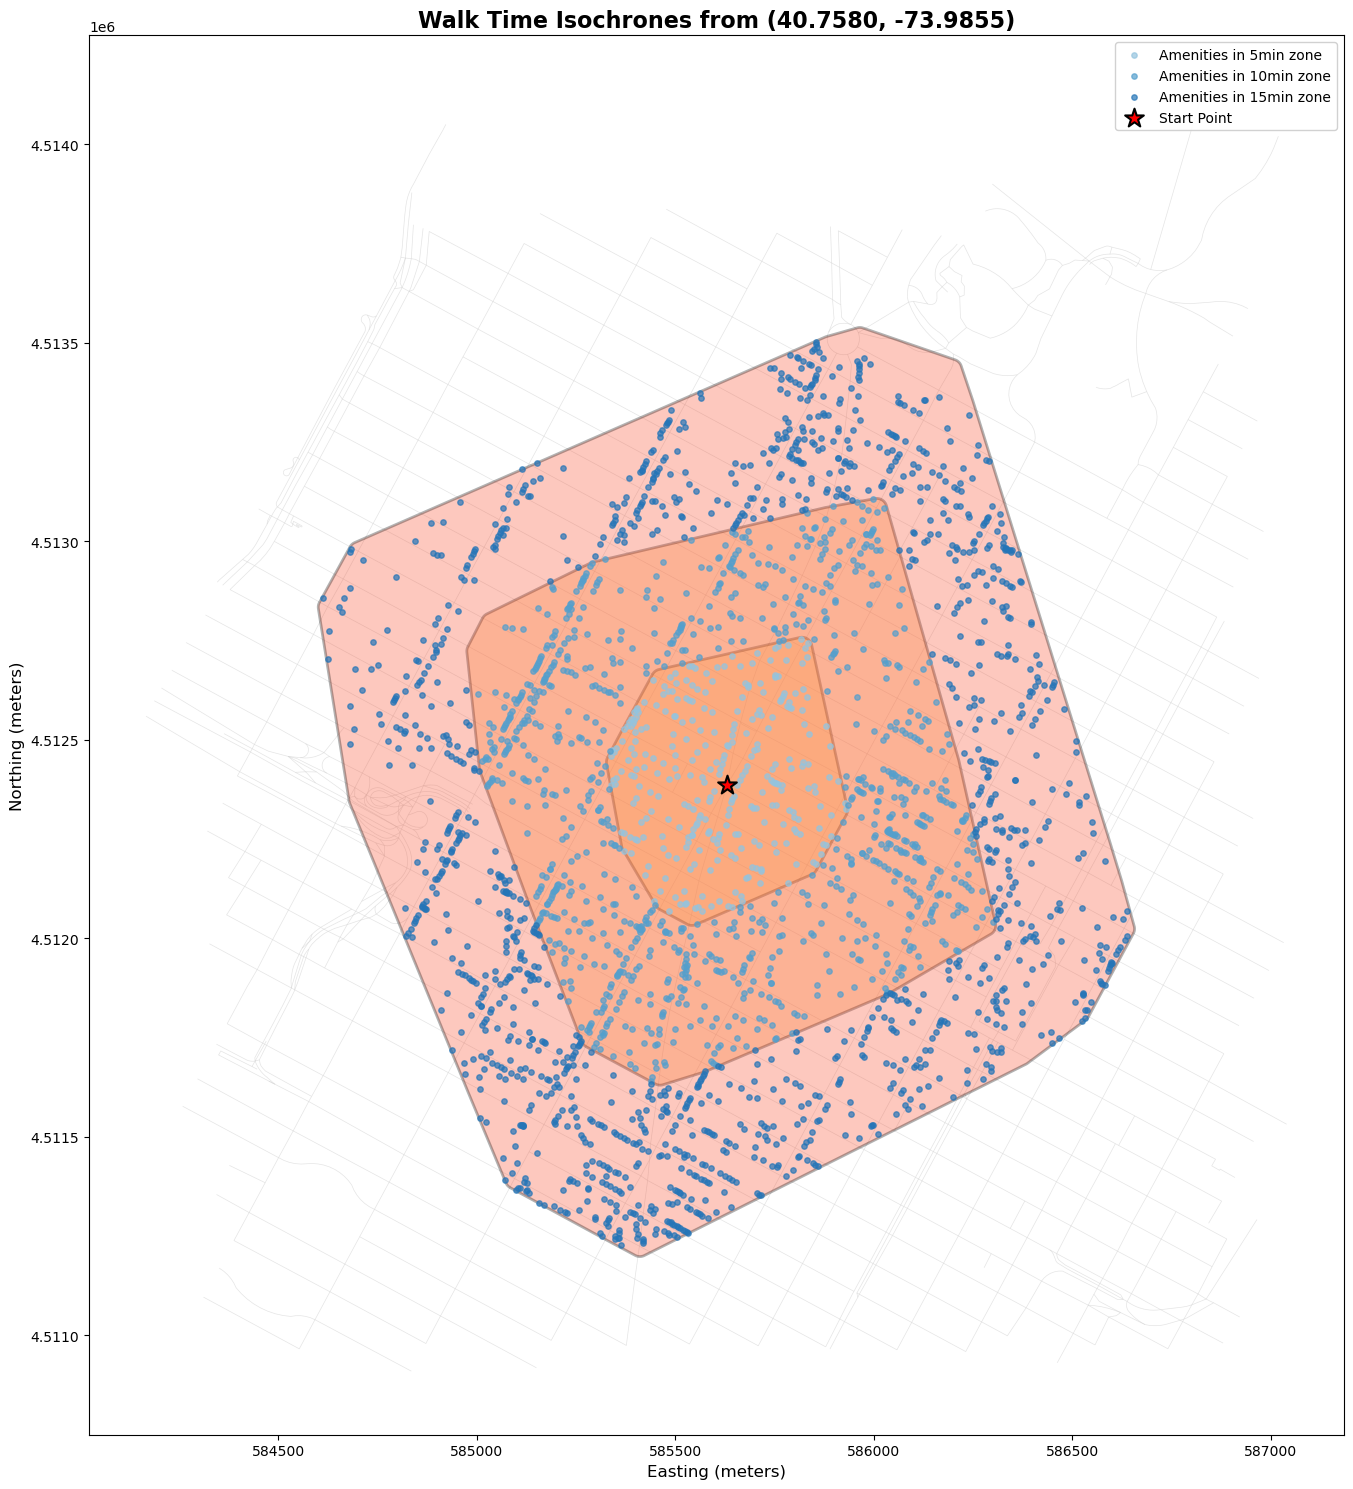


Time-based Walking Amenity Summary:
   distance_band  distance             amenity_type  count
0           0-5m         5             Urban Living    186
1           0-5m         5  Industry through design     91
2           0-5m         5                    Other     12
3           0-5m         5            uncategorized      9
4          5-10m        10             Urban Living    690
5          5-10m        10  Industry through design    193
6          5-10m        10                    Other     34
7          5-10m        10            uncategorized     25
8          5-10m        10                     Tech      6
9         10-15m        15             Urban Living    984
10        10-15m        15  Industry through design    262
11        10-15m        15                    Other     46
12        10-15m        15            uncategorized     46
13        10-15m        15                     Tech      7

Total amenities found: 2591

Amenities by time zone:
isochrone_distance
5    

/var/folders/mk/ks8rs6mx6_30xy34h6hr7cs00000gn/T/ipykernel_31093/3265081471.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')
/var/folders/mk/ks8rs6mx6_30xy34h6hr7cs00000gn/T/ipykernel_31093/3265081471.py:118: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  amenity_cmap = plt.cm.get_cmap('Blues')
/var/folders/mk/ks8rs6mx6_30xy34h6hr7cs00000gn/T/ipykernel_31093/3265081471.py:136: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=10, loc='upper ri

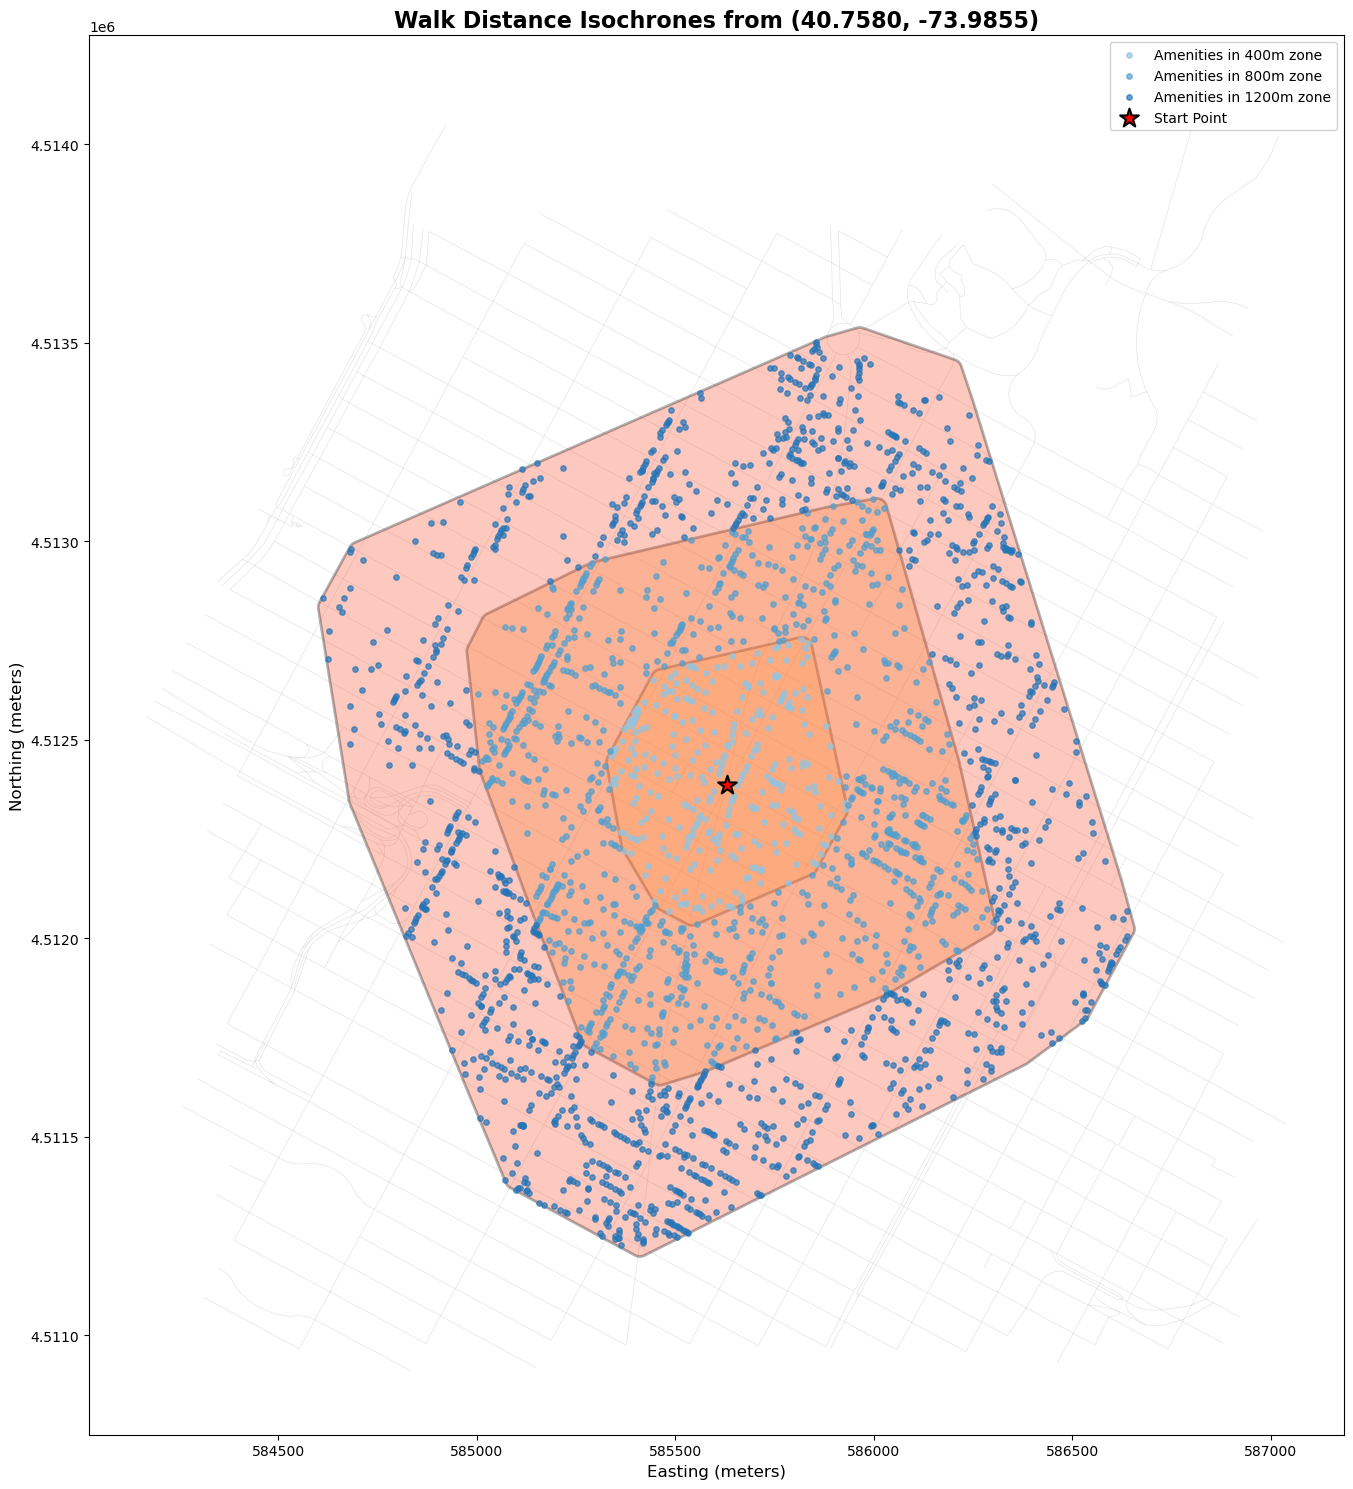


Amenity Summary:
   distance_band  distance             amenity_type  count
0         0-400m       400             Urban Living    186
1         0-400m       400  Industry through design     91
2         0-400m       400                    Other     12
3         0-400m       400            uncategorized      9
4       400-800m       800             Urban Living    690
5       400-800m       800  Industry through design    193
6       400-800m       800                    Other     34
7       400-800m       800            uncategorized     25
8       400-800m       800                     Tech      6
9      800-1200m      1200             Urban Living    984
10     800-1200m      1200  Industry through design    262
11     800-1200m      1200                    Other     46
12     800-1200m      1200            uncategorized     46
13     800-1200m      1200                     Tech      7

Total amenities found: 2591

Amenities by isochrone:
isochrone_distance
400      298
800      94

In [14]:
### NOT TESTED YET


def create_isochrone_analysis(location_type, location_value, mode='walk', distances=None, times=None,
                              roads_gdf=None, amenities_gdf=None, network_graph=None, 
                              visualize=True):
    """
    Complete isochrone analysis workflow.
    
    Parameters:
    -----------
    location_type : str
        One of 'coordinate', 'intersection', or 'amenity'
    location_value : tuple or list
        - For 'coordinate': (lat, lon)
        - For 'intersection': [street1, street2]
        - For 'amenity': amenity_name (string)
    mode : str
        Travel mode: 'walk', 'bike', or 'drive'
    distances : list, optional
        List of distances in meters for isochrones, e.g., [400, 800, 1200]
        Use either distances OR times, not both
    times : list, optional
        List of times in minutes for isochrones, e.g., [5, 10, 15]
        Use either distances OR times, not both
    roads_gdf : GeoDataFrame
        Roads data (required)
    amenities_gdf : GeoDataFrame
        Amenities data (required)
    network_graph : networkx.Graph
        Pre-built network graph (required)
    visualize : bool
        Whether to create a visualization
    
    Returns:
    --------
    dict : Dictionary containing isochrones, amenity summary, and detailed amenities
    """
    if roads_gdf is None or amenities_gdf is None or network_graph is None:
        raise ValueError("roads_gdf, amenities_gdf, and network_graph are required")
    
    # Check that either distances or times is provided, not both
    if distances is not None and times is not None:
        raise ValueError("Specify either 'distances' or 'times', not both")
    
    if distances is None and times is None:
        # Default to distance-based
        distances = [400, 800, 1200]
    
    # Determine if using time or distance
    use_time = times is not None
    
    # Get start node based on location type
    if location_type == 'coordinate':
        lat, lon = location_value
        start_node = get_location_from_coordinate(lat, lon, network_graph, roads_gdf.crs)
        title_suffix = f"from ({lat:.4f}, {lon:.4f})"
    elif location_type == 'intersection':
        street1, street2 = location_value
        start_node = get_location_from_intersection(street1, street2, roads_gdf, network_graph)
        title_suffix = f"from {street1} & {street2}"
    elif location_type == 'amenity':
        start_node = get_location_from_amenity(location_value, amenities_gdf, network_graph)
        title_suffix = f"from {location_value}"
    else:
        raise ValueError("location_type must be 'coordinate', 'intersection', or 'amenity'")
    
    # Generate isochrones
    if use_time:
        max_val = max(times)
        isochrones = generate_isochrone(network_graph, start_node, max_distance=None, mode=mode,
                                       use_time=True, max_time=max_val, time_intervals=times)
        unit = "min"
    else:
        max_val = max(distances)
        isochrones = generate_isochrone(network_graph, start_node, max_distance=max_val, mode=mode,
                                       distance_intervals=distances)
        unit = "m"
    
    # Analyze amenities
    amenity_summary = multi_distance_amenity_summary(amenities_gdf, isochrones)
    
    start_point = Point(start_node)
    
    # Assign amenities to isochrones
    amenities_assigned = assign_amenities_to_isochrones(amenities_gdf, isochrones)
    
    # Visualization
    if visualize:
        fig, ax = plt.subplots(figsize=(15, 15))
        
        # Get bounding box from isochrones to filter roads
        max_iso = isochrones[max(isochrones.keys())]
        bounds = max_iso.bounds
        buffer = 200
        minx, miny, maxx, maxy = bounds
        bbox = (minx - buffer, miny - buffer, maxx + buffer, maxy + buffer)
        
        # Filter and plot roads
        roads_subset = roads_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
        if len(roads_subset) > 0:
            roads_subset.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.6, zorder=1)
        
        # Create color gradient for isochrones
        cmap = plt.cm.get_cmap('YlOrRd')
        iso_colors = [cmap(0.3 + i*0.5/len(isochrones)) for i in range(len(isochrones))]
        
        # Plot isochrones
        for i, (val, geom) in enumerate(sorted(isochrones.items())):
            gpd.GeoSeries([geom], crs=roads_gdf.crs).plot(
                ax=ax, color=iso_colors[i], alpha=0.3, 
                edgecolor='black', linewidth=2,
                label=f'{val}{unit} {mode}', zorder=2
            )
        
        # Color amenities by which isochrone they're assigned to
        sorted_values = sorted(isochrones.keys())
        amenity_cmap = plt.cm.get_cmap('Blues')
        amenity_colors = [amenity_cmap(0.4 + i*0.5/len(sorted_values)) for i in range(len(sorted_values))]
        
        for i, val in enumerate(sorted_values):
            in_isochrone = amenities_assigned[amenities_assigned['isochrone_distance'] == val]
            
            if len(in_isochrone) > 0:
                in_isochrone.plot(ax=ax, color=amenity_colors[i], markersize=15, 
                            alpha=0.7, label=f'Amenities in {val}{unit} zone',
                            zorder=3)
        
        # Plot start point
        gpd.GeoSeries([start_point], crs=roads_gdf.crs).plot(
            ax=ax, color='red', markersize=200, 
            marker='*', label='Start Point', zorder=4, 
            edgecolor='black', linewidth=1.5
        )
        
        ax.legend(fontsize=10, loc='upper right', framealpha=0.9)
        title_type = "Time" if use_time else "Distance"
        ax.set_title(f'{mode.title()} {title_type} Isochrones {title_suffix}', fontsize=16, fontweight='bold')
        ax.set_xlabel('Easting (meters)', fontsize=12)
        ax.set_ylabel('Northing (meters)', fontsize=12)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()
    
    return {
        'isochrones': isochrones,
        'isochrone_gdf': create_isochrone_geodataframe(isochrones, roads_gdf.crs, is_time=use_time),
        'amenity_summary': amenity_summary,
        'amenities_assigned': amenities_assigned,
        'start_node': start_node,
        'start_point': start_point,
        'use_time': use_time
    }

# Example: Time-based walking isochrones
time_walk_result = create_isochrone_analysis(
    location_type='coordinate',
    location_value=(40.7580, -73.9855),  # Times Square
    mode='walk',
    times=[5, 10, 15],  # minutes
    roads_gdf=roads,
    amenities_gdf=amenities,
    network_graph=G,
    visualize=True
)

print("\nTime-based Walking Amenity Summary:")
print(time_walk_result['amenity_summary'])
print(f"\nTotal amenities found: {len(time_walk_result['amenities_assigned'])}")
print("\nAmenities by time zone:")
print(time_walk_result['amenities_assigned'].groupby('isochrone_distance').size())


# Example: Distance-based walking isochrones
result = create_isochrone_analysis(
    location_type='coordinate',
    location_value=(40.7580, -73.9855),  # Times Square
    mode='walk',
    distances=[400, 800, 1200],
    roads_gdf=roads,
    amenities_gdf=amenities,
    network_graph=G,
    visualize=True
)

print("\nAmenity Summary:")
print(result['amenity_summary'])
print(f"\nTotal amenities found: {len(result['amenities_assigned'])}")
print("\nAmenities by isochrone:")
print(result['amenities_assigned'].groupby('isochrone_distance').size())